# Supervised Learning in Breast Cancer Data

##1.prepare the dataset for supervised clustering

We applied unsupervised learning to identify the breast cancer subtypes in the last part. What we discovered was that different subtypes were associated with various clinical outcomes. But we didn't actually know the accuracy of our clustering. If low accuracy occurred, the conclusion we got was questionable. Therefore, we came up with an idea to conduct supervised learning according to the reliable subtype classification information from the literature.

In [2]:
%matplotlib inline
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

In [3]:
#Read-in the data with cancer subtype information
brca_info = pd.read_csv('brca_information.txt', sep='\t')
brca_info.head()

,Complete TCGA ID,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor__T1 Coded,Node,Node_Coded,Metastasis,Metastasis_Coded,AJCC Stage,Converted Stage,Survival Data Form,Vital Status,Days to Date of Last Contact,Days to date of Death,OS event,OS Time,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
0,TCGA-A2-A0T2,FEMALE,66,Negative,Negative,Negative,T3,T_Other,N3,Positive,M1,Positive,Stage IV,No_Conversion,followup,DECEASED,240,240,1,240,Basal_like,0,_13,3,5,Basal,3,2,2,2
1,TCGA-A2-A04P,FEMALE,36,Negative,Negative,Negative,T2,T_Other,N3,Positive,M0,Negative,Stage IIIC,No_Conversion,followup,DECEASED,547,547,1,547,Basal_like,0,_13,5,5,Basal,1,2,2,2
2,TCGA-A1-A0SK,FEMALE,54,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,Negative,Stage IIA,Stage IIA,followup,DECEASED,594,967,1,967,Basal_like,_6,_13,5,5,Basal,1,2,2,2
3,TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,Negative,Stage IIA,Stage IIA,followup,DECEASED,754,754,1,754,Basal_like,_12,_13,4,4,Basal,4,2,1,1
4,TCGA-AR-A1AR,FEMALE,50,Negative,Negative,Negative,T1,T1,N2,Positive,M0,Negative,Stage III,Stage IIIA,enrollment,DECEASED,[Not Available],523,1,523,Basal_like,0,_13,5,5,NaN,1,NaN,NaN,NaN


In [7]:
#pick oout the sample barcode and subtype information and clean the data (remove the NA)
brca_sub = brca_info[['Complete TCGA ID','PAM50 mRNA']].dropna()

In [8]:
brca_sub = brca_sub[0:514] #delete the normal sample
brca_sub.rename(columns={'Complete TCGA ID':'id', 'PAM50 mRNA':'subtype'}, inplace=True)

Here there are four tumor subtypes listed in this table (Basal_like, HER2_enriched, Luminal A and Luminal B). We merged Luminal A and Luminal B into one group and added a subtype_indicator variable to simplify our further analysis (0,1,2 means Basal_like, HER2_enriched and Luminal, respetively).

In [13]:
subtype_indicator = []
for i in brca_sub['subtype']:
    if i == 'Basal_like':
        subtype_indicator.append(0)
    elif i == 'HER2_enriched':
        subtype_indicator.append(1)
    else:
        subtype_indicator.append(2)
        
brca_sub['subtype_indicator'] = subtype_indicator

In [14]:
brca_sub.head()

,id,subtype,subtype_indicator
0,TCGA-A2-A0T2,Basal_like,0
1,TCGA-A2-A04P,Basal_like,0
2,TCGA-A1-A0SK,Basal_like,0
3,TCGA-A2-A0CM,Basal_like,0
4,TCGA-AR-A1AR,Basal_like,0


In [19]:
# the list of tumor barcode and their corresponding subtype indicator.
id_list = np.array(brca_sub.id)
ind_list = np.array(brca_sub['subtype_indicator'])

In [27]:
# Read the expression file and clean the data
f = open("brca.txt","rb")
headers = str(f.next()).strip('[').strip(']').strip("'").replace('"','').split() 
f.close()
df = pd.read_csv('brca.txt', sep=' ',names=['index'] + headers,low_memory=False)
brca = df.ix[1:]

Then we bulit a dictionary subtype_id with the key as the sample barcodes that occur in both the expression file and the information file and the indicators as its values and picked out the samples from the expression file.

In [20]:
subtype_id = {}
for barcode in brca.columns:
    for i in range(len(id_list)): 
        if barcode[0:12] == id_list[i]:
            if barcode[13:15]!='11':
                subtype_id[barcode] = ind_list[i]

In [21]:
#adjust the dataset  
brca_subtype = brca[subtype_id.keys()]
brca_subtype = brca_subtype.set_index(brca['index'])

In [22]:
brca_subtype_trans = brca_subtype.transpose()
brca_subtype_trans['subtype'] = subtype_id.values()

In [23]:
#calculate the number of samples in each group
brca_subtype_trans.groupby('subtype').count()['ZXDA|7789']

subtype
0     98
1     58
2    362
Name: ZXDA|7789, dtype: int64

In [24]:
brca_subtype_trans_sorted = brca_subtype_trans.sort('subtype', ascending=True)
brca_subtype_trans_sorted = pd.DataFrame(brca_subtype_trans_sorted, dtype='float')

In [25]:
brca_for_test = brca_subtype_trans_sorted.transpose()
brca_for_r = brca_for_test[:-1]

In [26]:
brca_for_r.to_csv("brca_for_r.csv")

Here we applied the Limma from R (Bioconductor), linear Models for Microarray and RNA-Seq Data, to discover the differential expressed genes among three subtypes and to perform the multiple hypothesis testing to adjust the p-values. Then we picked out the top 100 genes that have the smallest adjusted p-value, the codes are:

####library(limma)
####brca <- read.csv("brca_for_r.csv",header=T,row.names=1)
####design <- c(rep(0,98),rep(1,58),rep(2,362))
####design.mat <- model.matrix(~design)
####fit <- lmFit(brca,design.mat)
####fit <- eBayes(fit)
####brca_deg <- topTable(fit,coef = "design",number=100,p.value=0.01)
####write.table(row.names(brca_deg),file="brca_deg_list.txt",quote=F,sep="\t")


In [28]:
# read the list of differential expressed genes which is the output of the previous step
brca_deg = pd.read_csv('brca_deg_list.txt', sep='\t')

In [32]:
brca_deg_list = list(brca_deg.x)
breast_cancer = brca_for_test.loc[brca_deg_list,:].transpose()

In [33]:
breast_cancer.head()

index,FOXA1|3169,FAM171A1|221061,B3GNT5|84002,RGMA|56963,CDCA7|83879,C11orf75|56935,TTLL4|9654,BCL11A|53335,UQCRHL|440567,PADI2|11240,SFRS13B|135295,EN1|2019,FOXC1|2296,UCK2|7371,CXorf61|203413,UQCRH|7388,GABRP|2568,HMGA1|3159,ZNF462|58499,TCF7L1|83439,PSAT1|29968,PRKX|5613,IFRD1|3475,CDC20|991,KIAA1804|84451,GLIPR2|152007,GATA3|2625,MEMO1|51072,MLPH|79083,NCK2|8440,MICALL1|85377,CEBPB|1051,PDSS1|23590,TSPAN33|340348,ANP32E|81611,ZNF454|285676,FAM123B|139285,CDH3|1001,ENO1|2023,ST8SIA1|6489,ZNF695|57116,CDK2AP1|8099,CDCA8|55143,AURKB|9212,C12orf10|60314,SFT2D2|375035,FMNL2|114793,MTHFD1L|25902,SKP1|6500,SLC43A3|29015,HAPLN3|145864,MFSD2B|388931,XBP1|7494,ELF5|2001,UBE2E3|10477,HRASLS|57110,DNALI1|7802,POLR2F|5435,NASP|4678,RASAL1|8437,AKR1E2|83592,SUV39H2|79723,USP6NL|9712,PHGDH|26227,LMO4|8543,C9orf30|91283,KIF2C|11004,ZBTB7A|51341,BTF3|689,CENPA|1058,STMN1|3925,RHOB|388,TMSB15B|286527,TBX19|9095,ILF2|3608,TTC8|123016,CDKN2A|1029,LDHB|3945,TMBIM6|7009,SOX10|6663,NDC80|10403,TTK|7272,FLJ36031|168455,CLCN4|1183,ANKRA2|57763,IVD|3712,KIAA0141|9812,CHCHD5|84269,CCDC82|79780,PELI1|57162,NT5DC2|64943,PPP1R14C|81706,KIAA0020|9933,ZIC1|7545,MELK|9833,DAZAP2|9802,MEX3A|92312,CDC42EP1|11135,CENPN|55839,ATL2|64225
TCGA-AN-A04D-01A-21R-A034-07,1.730230e-06,0.000041,0.000039,0.000102,0.000026,0.000085,0.000055,0.000040,0.000364,0.000111,4.274570e-06,0.000079,0.000060,0.000128,0.000024,0.001476,0.000409,0.000247,0.000011,0.000058,0.000009,0.000015,0.000039,0.000141,0.000011,0.000166,4.660106e-07,0.000034,0.000004,0.000056,0.000028,0.000145,0.000029,0.000046,0.000161,0.000005,0.000007,0.000003,0.000528,0.000004,0.000018,0.001317,0.000092,0.000047,0.000045,0.000037,0.000022,0.000014,0.000207,0.000047,0.000071,0.000004,0.000280,0.000197,0.000223,0.000021,7.460657e-07,0.000066,0.000283,0.000012,0.000009,0.000013,0.000021,0.000274,0.000265,0.000031,0.000108,0.000009,0.000358,0.000034,0.001064,0.000114,0.000049,0.000009,0.000891,0.000006,6.239159e-05,0.000620,0.000641,0.000415,0.000053,0.000031,0.000006,0.000001,0.000006,0.000003,0.000025,0.000031,0.000018,0.000023,0.000054,2.992853e-07,0.000063,2.426209e-05,0.000039,0.000211,0.000144,0.000060,0.000019,0.000214
TCGA-AR-A0TP-01A-11R-A084-07,3.049591e-06,0.000024,0.000023,0.000045,0.000022,0.000074,0.000013,0.000026,0.000138,0.000192,1.937751e-06,0.000068,0.000049,0.000051,0.000049,0.000514,0.000248,0.000146,0.000049,0.000041,0.000050,0.000027,0.000039,0.000055,0.000021,0.000049,2.739239e-07,0.000025,0.000008,0.000146,0.000045,0.000065,0.000009,0.000115,0.000093,0.000002,0.000003,0.000024,0.002900,0.000008,0.000002,0.000567,0.000025,0.000019,0.000019,0.000057,0.000028,0.000013,0.000121,0.000151,0.000196,0.000003,0.000353,0.000046,0.000087,0.000006,4.270029e-07,0.000044,0.000071,0.000017,0.000005,0.000006,0.000017,0.000878,0.000111,0.000034,0.000020,0.000009,0.000580,0.000012,0.000550,0.000089,0.000020,0.000020,0.000398,0.000009,1.139181e-04,0.000596,0.000343,0.000295,0.000022,0.000016,0.000013,0.000002,0.000004,0.000019,0.000010,0.000023,0.000043,0.000042,0.000090,5.990495e-06,0.000046,1.169343e-07,0.000024,0.000118,0.000031,0.000170,0.000017,0.000066
TCGA-BH-A0BG-01A-11R-A115-07,5.892785e-07,0.000055,0.000010,0.000039,0.000014,0.000062,0.000048,0.000021,0.000178,0.000217,5.934668e-07,0.000080,0.000062,0.000057,0.000037,0.000535,0.001199,0.000206,0.000016,0.000050,0.000028,0.000024,0.000021,0.000046,0.000012,0.000068,1.236405e-05,0.000033,0.000005,0.000093,0.000029,0.000120,0.000008,0.000049,0.000064,0.000001,0.000006,0.000150,0.001937,0.000005,0.000002,0.000462,0.000016,0.000036,0.000032,0.000037,0.000038,0.000012,0.000147,0.000152,0.000235,0.000004,0.000220,0.000370,0.000137,0.000004,1.138655e-06,0.000030,0.000081,0.000005,0.000004,0.000009,0.000025,0.000079,0.000105,0.000029,0.000020,0.000013,0.000642,0.000011,0.000332,0.000060,0.000022,0.000025,0.000321,0.000015,1.658079e-06,0.000687,0.000300,0.000180,0.000034,0.000011,0.000022,0.000014,0.000005,0.000011,0.000018,0.000032,0.000035,0.000030,0.0

##2. Linear Support Vector Machine

In [34]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(breast_cancer.shape[0]), train_size=0.8) #split the samples into 80% training samples and 20% testing samples

In [35]:
mask=np.ones(breast_cancer.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [36]:
Xmatrix_train=breast_cancer[mask]
Xmatrix_test=breast_cancer[~mask]
Yresp_train=brca_subtype_trans_sorted['subtype'][mask]
Yresp_test=brca_subtype_trans_sorted['subtype'][~mask]

In [37]:
# Use the expression of each gene as a feature for the model.
from sklearn.svm import LinearSVC
clfsvm=LinearSVC(loss="hinge")
clfsvm.fit(Xmatrix_train, Yresp_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [38]:
training_accuracy_svm_linear = clfsvm.score(Xmatrix_train, Yresp_train)
test_accuracy_svm_linear = clfsvm.score(Xmatrix_test, Yresp_test)
print "Accuracy on training data: %0.4f" % (training_accuracy_svm_linear)
print "Accuracy on test data:     %0.4f" % (test_accuracy_svm_linear)

Accuracy on training data: 0.6957
Accuracy on test data:     0.7115


Discussion: We found low accuracy because this classifier grouped all the samples in the same group, the reasons behind this might be: 1. there are still strong correlations between expression patterns of genes though the genes we picked out are the most differential expressed ones; 2. The number of samples for each group is not sufficient and the group "Lumina" is in the majority of all samples, which exerts a significant effect on the SVM classifier.

In [85]:
clfsvm.predict(Xmatrix_test)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

##3. K Nearest Joining Method

In [39]:
from sklearn.neighbors import KNeighborsClassifier

In [40]:
def classify(X,y, nbrs, train_size=0.8):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf= KNeighborsClassifier(nbrs)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    Xall=np.concatenate((Xtrain, Xtest))  
    return nbrs, training_accuracy, test_accuracy

In [41]:
print classify(breast_cancer,brca_subtype_trans_sorted['subtype'], 3)

(3, 0.92270531400966183, 0.91346153846153844)


In [43]:
fits={}
for k in np.arange(1,100,1):
    fits[k]=[]
    for i in range(100):
        fits[k].append(classify(breast_cancer, brca_subtype_trans_sorted['subtype'],k))

In [44]:
nbrs=np.arange(1,100,1)
fmeanstr = np.array([1.-np.mean([t[1] for t in fits[e]]) for e in nbrs])
fmeanste = np.array([1.-np.mean([t[2] for t in fits[e]]) for e in nbrs])
fstdsstr = np.array([np.std([t[1] for t in fits[e]]) for e in nbrs])
fstdsste = np.array([np.std([t[2] for t in fits[e]]) for e in nbrs])

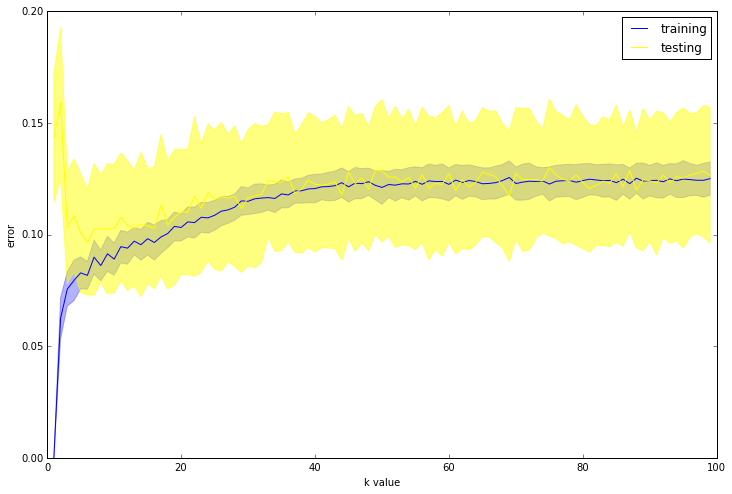

In [49]:
plt.figure(figsize=(12,8))
plt.plot(nbrs, fmeanstr, color='blue', label="training");
plt.fill_between(nbrs, fmeanstr - fstdsstr, fmeanstr+fstdsstr, color='blue', alpha=0.3)
plt.plot(nbrs, fmeanste, color='yellow', label="testing");
plt.fill_between(nbrs, fmeanste - fstdsste, fmeanste+fstdsste, color='yellow', alpha=0.5)
plt.xlabel('k value')
plt.ylabel('error')
plt.legend();

Here we plotted the test error and training error against the number of neighbors k. We can see that small k is more wiggly in the classification of neighborhoods and large k oversmooths the classification. As expected, the training error arises with complexity (k serves as a complexity parameter), but the test error decreases drastically at first and then slightly increases. There is a range of k from 15 to 5, in which the fit is as good as it gets. Thus we pick k=10 in our final model.

In [58]:
clfknn = KNeighborsClassifier(10)
clfknn.fit(Xmatrix_train, Yresp_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=10, p=2, weights='uniform')

In [59]:
training_accuracy_knn = clfknn.score(Xmatrix_train, Yresp_train)
test_accuracy_knn = clfknn.score(Xmatrix_test, Yresp_test)
print "Accuracy on training data: %0.4f" % (training_accuracy_knn)
print "Accuracy on test data:     %0.4f" % (test_accuracy_knn)

Accuracy on training data: 0.9130
Accuracy on test data:     0.8942


## Conclusion and Discussion

We can see the accuracy of KNN classifier is around 90% in the test set. If we would like to go further, we can predict the remaining samples that has not been labeled (no subtype information) and compare the subtype prediction with the previous unsupervised clustering results in the first part. If there is a high correlation between them, we have reasons to believe that the unsupervised clustering results are reliable. 